# Detailed Variant Report v0.1

## Data Input

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format

configFile='detailed_var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['pipeline_version','run_id','h5_concordance_file']

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

h5outfile = parser.get('VarReport', 'h5_output', fallback='detailed_var_report.h5')
    
source = prm['h5_concordance_file']

chromData=[]

chrKeys=['/chr{:d}'.format(i+1) for i in range(22)]

for k in chrKeys:
    d=pd.read_hdf(source, key=k, mode='r')
    chromData.append(d)

print([len(chromData[i]) for i in range(len(chromData))])

data=pd.concat(chromData)
data['tree_score'] = np.where(data['classify']=='fn',-1,data['tree_score'])
print(len(data))
chromData=[]

prm['mean_var_depth']='{:.2f}'.format(data['well_mapped_coverage'].mean())
prmNames.append('mean_var_depth')
   
try:
    args=pd.read_hdf(sources[0], 'input_args', mode='r')
    prm['truth_sample_name']=args['truth_sample_name'][0]
except:
    prm['truth_sample_name']=parser.get('VarReport', 'truth_sample_name', fallback='NA')
prmNames.append('truth_sample_name')

prm['regions']=parser.get('DetailedReport', 'regions').split(',')
prmNames.append('regions')


prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="det_parameters")
prmdf

[331943, 324804, 294498, 250978, 245167, 269345, 228733, 198709, 178693, 209362, 211003, 188091, 160702, 137155, 118052, 73978, 107093, 98720, 84257, 90759, 57386, 47946]
3907374


/home/ec2-user/.local/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['value'], dtype='object')]

  encoding=encoding,


,value
run_id,170280-BC04
h5_concordance_file,170280-BC10.vcf_compare.wg.h5
mean_var_depth,44.98
truth_sample_name,HG001
regions,"[exome.twist, LCR-hs38, Non-LCR-hs38]"


In [2]:
prm['regions']

['exome.twist', 'LCR-hs38', 'Non-LCR-hs38']

In [3]:
data

,chrom,pos,ref,alleles,gt_ultima,gt_ground_truth,indel,classify,classify_gt,filter,...,well_mapped_coverage,repetitive_read_coverage,close_to_hmer_run,inside_hmer_run,mappability.0,exome.twist,LCR-hs38,cycleskip_status,compare_to_gtr_changes,compare_to_gtr_hmer_indel_len
"(chr1, 817186)",chr1,817186,G,"(G, A)","(1, 1)","(1, 1)",False,tp,tp,PASS,...,53,0,False,False,True,False,False,cycle-skip,nan%,NaN
"(chr1, 817341)",chr1,817341,A,"(A, G)","(1, 1)","(1, 1)",False,tp,tp,PASS,...,57,0,False,False,True,False,False,non-skip,nan%,NaN
"(chr1, 817889)",chr1,817889,C,"(C, G)","(1, 1)","(1, 1)",False,tp,tp,PASS,...,8,35,False,False,True,False,False,possible-cycle-skip,nan%,NaN
"(chr1, 818802)",chr1,818802,A,"(A, G)","(1, 1)","(1, 1)",False,tp,tp,PASS,...,48,8,False,False,True,False,False,cycle-skip,nan%,NaN
"(chr1, 818812)",chr1,818812,A,"(A, G)","(1, 1)","(1, 1)",False,tp,tp,PASS,...,52,8,False,False,True,False,False,possible-cycle-skip,nan%,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(chr22, 49973074)",chr22,49973074,T,"(T, G)","(1, 1)","(1, 1)",False,tp,tp,PASS,...,47,0,False,False,True,False,True,non-skip,nan%,NaN
"(chr22, 49973077)",chr22,49973077,C,"(C, G)","(1, 1)","(1, 1)",False,tp,tp,PASS,...,49,2,False,False,True,False,False,possible-cycle-skip,nan%,NaN
"(chr22, 49973092)",chr22,49973092,C,"(C, G)","(1, 1)","(1, 1)",False,tp,tp,PASS,...,63,31,False,False,True,False,False,cycle-skip,nan%,NaN
"(chr22, 49973279)",chr22,49973279,A,"(A, G)","(1, 1)","(1, 1)",False,tp,tp,PASS,...,48,0,False,False,True,False,False,possible-cycle-skip,nan%,NaN


In [4]:
data.columns

Index(['chrom', 'pos', 'ref', 'alleles', 'gt_ultima', 'gt_ground_truth',
       'indel', 'classify', 'classify_gt', 'filter', 'qual', 'sor', 'as_sor',
       'as_sorp', 'fs', 'vqsr_val', 'qd', 'dp', 'ad', 'tree_score',
       'indel_classify', 'indel_length', 'hmer_indel_length', 'hmer_indel_nuc',
       'left_motif', 'right_motif', 'gc_content', 'coverage',
       'well_mapped_coverage', 'repetitive_read_coverage', 'close_to_hmer_run',
       'inside_hmer_run', 'mappability.0', 'exome.twist', 'LCR-hs38',
       'cycleskip_status', 'compare_to_gtr_changes',
       'compare_to_gtr_hmer_indel_len'],
      dtype='object')

## Filter Definitions

In [5]:
def filterByRegion(data,region):
    if region=='All':
        return data
    elif region.startswith('Non-'):
        return data[data[region[4:]]==False]
    else:
        return data[data[region]==True]

def filterByRange(data,prm,mn,mx):
    return data[(data[prm]>=mn) & (data[prm]<mx)]

def filterByVarCategory(data,cat):
    if cat=='All':
        return data
    if cat=='SNP':
        return data[data['indel']==False]
    elif cat=='cycleskip SNP':
        return data[(data['indel']==False) & (data['cycleskip_status'])==True]
    elif cat=='Indel':
        return data[data['indel']==True]
    elif cat=='non-hmer':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>1)]
    elif cat=='hmer 0-1':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']==1)]
    elif cat=='hmer 2-4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer 5-8':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<=8)]
    elif cat=='hmer 9-10':
        return data[(data['indel']==True) & (data['hmer_indel_length']>8) & (data['hmer_indel_length']<=10)]
    elif cat=='hmer 11+':
        return data[(data['indel']==True) & (data['hmer_indel_length']>10)]
    return None


In [6]:
def calcPerformance(data, gt=False):
    classify='classify_gt' if gt else 'classify'
    
    d=data.copy()
    d=d[[classify,'tree_score']].sort_values(by=['tree_score'])
    d['label'] = np.where(d[classify]=='fp',0,1)

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num==0:
        return (pd.DataFrame(),None,numPos,numNeg)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['f1']=d['tp']/(d['tp']+0.5*d['fn']+0.5*d['fp'])

    d['mask']=((d['tp']+d['fn'])>=1) & ((d['tp']+d['fp'])>=1) & (d['tree_score']>=0)
    if len(d[d['mask']])==0:
        return (pd.DataFrame(),None,numPos,numNeg)
    
    maxF1=max(d[d['mask']]['f1'])
    d['opt']=(d['f1']==maxF1)

    return (d[['recall','precision']][d['mask']],
            d[['recall','precision','f1','tp','fp','fn','tree_score']][d['opt'] & d['mask']],
            numPos,numNeg)


def renameReg(reg):
    regRename={"LCR-hs38": "LCR", "Non-LCR-hs38": "Non-LCR", "exome.twist": "Exome"}
    return regRename[reg] if reg in regRename else reg
    


def getStats(d,reg,cat,var):
    perf,opt,pos,neg=calcPerformance(d)
    mi=pd.MultiIndex.from_tuples([(renameReg(reg),var,cat)],names=['Region','Variant','Category'])

    row=pd.DataFrame({'# pos':pos,
                      '# neg':neg,
                      'TP':np.nan if perf.empty else int(opt.tp[0]),
                      'FP':np.nan if perf.empty else opt.fp[0],
                      'FN':np.nan if perf.empty else opt.fn[0],
                      'max recall':np.nan if perf.empty else max(perf.recall),
                      'recall':np.nan if perf.empty else opt.recall[0],
                      'precision':np.nan if perf.empty else opt.precision[0],
                      'F1':np.nan if perf.empty else opt.f1[0],
                      #'thresh':'{:,.4f}'.format(opt.tree_score[0]),
                      'avg cvg':d['coverage'].mean(),
                      'avg gc':d['gc_content'].mean(),
                     },index=mi)
    

    return row


## Performance Calculation

In [7]:
pd.options.display.float_format = lambda x: '{:,.2%}'.format(x) if x<=1 and x>0 else \
                                           ('{:,.0f}'.format(x) if x.is_integer() else \
                                            '{:,.1f}'.format(x))

varCats=['All','SNP','Indel','non-hmer','hmer 0-1','hmer 2-4','hmer 5-8','hmer 9-10','hmer 11+']
#varCats=['SNP','Indel']
#varCats=['hmer Indel >8,<=10','hmer Indel >10']


res=pd.DataFrame()
for region in ['All']+prm['regions']:
#for region in ['exome.twist']:
    d1=filterByRegion(data,region)
    
    for var in varCats:
        print(region,var)
        d2=filterByVarCategory(d1,var)
        res=pd.concat([res,getStats(d2,region, 'All', var)])
        
        for gc in [(0,0.2),(0.2,0.8),(0.8,1)]:
            d3=filterByRange(d2,'gc_content',gc[0],gc[1])
            res=pd.concat([res,getStats(d3,region, 'GC {0}-{1}'.format(gc[0],gc[1]), var)])
        for cvg in [(0,20),(20,40),(40,100)]:
            d3=filterByRange(d2,'coverage',cvg[0],cvg[1])
            res=pd.concat([res,getStats(d3,region, 'CVG {0}-{1}'.format(cvg[0],cvg[1]), var)])
        for mappab in [True,False]:
            d3=filterByRange(d2,'mappability.0',mappab-1,mappab)
            res=pd.concat([res,getStats(d3,region, 'Mappable {0}'.format(mappab), var)])
       

All All
All SNP
All Indel
All non-hmer
All hmer 0-1
All hmer 2-4
All hmer 5-8
All hmer 9-10
All hmer 11+
exome.twist All
exome.twist SNP
exome.twist Indel
exome.twist non-hmer
exome.twist hmer 0-1
exome.twist hmer 2-4
exome.twist hmer 5-8
exome.twist hmer 9-10
exome.twist hmer 11+
LCR-hs38 All
LCR-hs38 SNP
LCR-hs38 Indel
LCR-hs38 non-hmer
LCR-hs38 hmer 0-1
LCR-hs38 hmer 2-4
LCR-hs38 hmer 5-8
LCR-hs38 hmer 9-10
LCR-hs38 hmer 11+
Non-LCR-hs38 All
Non-LCR-hs38 SNP
Non-LCR-hs38 Indel
Non-LCR-hs38 non-hmer
Non-LCR-hs38 hmer 0-1
Non-LCR-hs38 hmer 2-4
Non-LCR-hs38 hmer 5-8
Non-LCR-hs38 hmer 9-10
Non-LCR-hs38 hmer 11+


In [8]:
pd.set_option('display.max_rows', 1000)
res

# pos   # neg        TP      FP      FN  \
Region  Variant   Category                                                    
All     All       All             3439443  467931 3,225,426  58,909 214,017   
                  GC 0-0.2         261261   37033   207,654  12,709  53,607   
                  GC 0.2-0.8      3045258  390630 2,892,448  42,977 152,810   
                  GC 0.8-1         129421   38568   125,506   6,282   3,915   
                  CVG 0-20          92633   10403    50,746   2,986  41,887   
                  CVG 20-40        950689  112231   880,908  18,124  69,781   
                  CVG 40-100      2392237  342412 2,297,474  40,254  94,763   
                  Mappable True     27949     718    13,443     714  14,506   
                  Mappable False        0       0       nan     nan     nan   
        SNP       All             2959444   31806 2,910,278  14,803  49,166   
                  GC 0-0.2         160424    4984   152,822   1,644   7,602   
                  GC 0.2-0.8      2676704   23835 2,638,001  12,231  38,703   
                  GC 0.8-1         119438    2763   116,731     748   2,707   
                  CVG 0-20          59431    2889    41,150     801  18,281   
                  CVG 20-40        796169    7318   777,609   1,829  18,560   
                  CVG 40-100      2103156   18957 2,090,638   8,787  12,518   
                  Mappable True     27014     488    13,035     487  13,979   
                  Mappable False        0       0       nan     nan     nan   
        Indel     All              479999  436125   322,409  51,682 157,590   
                  GC 0-0.2         100837   32049    54,886  10,782  45,951   
                  GC 0.2-0.8       368554  366795   253,734  27,618 114,820   
                  GC 0.8-1           9983   35805     8,662   4,651   1,321   
                  CVG 0-20          33202    7514     9,659   2,320  23,543   
                  CVG 20-40        154520  104913   102,076  14,443  52,444   
                  CVG 40-100       289081  323455   205,800  26,417  83,281   
                  Mappable True       935     230       391      62     544   
                  Mappable False        0       0       nan     nan     nan   
        non-hmer  All              179657   12106   144,633   3,664  35,024   
                  GC 0-0.2          25136    1837    13,852     435  11,284   
                  GC 0.2-0.8       151864    9565   128,515   2,963  23,349   
                  GC 0.8-1           2468     648     2,105      80     363   
                  CVG 0-20          25129    1050     7,302   1,039  17,827   
                  CVG 20-40         56088    4120    47,875   1,371   8,213   
                  CVG 40-100        95350    6827    89,885   1,511   5,465   
                  Mappable True       300      11       115      10     185   
                  Mappable False        0       0       nan     nan     nan   
        hmer 0-1  All               29279   23059    27,181     905   2,098   
                  GC 0-0.2           5066     573     4,321     152     745   
                  GC 0.2-0.8        22573   17210    21,459     693   1,114   
                  GC 0.8-1           1516    5175     1,413      45     103   
                  CVG 0-20           1206     803       605     121     601   
                  CVG 20-40          8687    6090     8,014     251     673   
                  CVG 40-100        19337   16127    18,674     553     663   
                  Mappable True       128      51        71       4      57   
                  Mappable False        0       0       nan     nan     nan   
        hmer 2-4  All               54014  341017    51,628   2,006   2,386   
                  GC 0-0.2           4077   11846     3,534     198     543   
                  GC 0.2-0.8        47844  303208    46,167   1,546   1,677   
                  GC 0.8-1           2022   25081     1,841     134     181   
       

In [9]:
res.to_hdf(h5outfile, key="detailed_vars")

parser.read(configFile)
csvFile=parser.get('DetailedReport', 'csv')

out=res.reset_index()
out.to_csv(csvFile,index=False)
out

,Region,Variant,Category,# pos,# neg,TP,FP,FN,max recall,recall,precision,F1,avg cvg,avg gc
0,All,All,All,3439443,467931,"3,225,426","58,909","214,017",94.31%,93.78%,98.21%,95.94%,46.2,42.28%
1,All,All,GC 0-0.2,261261,37033,"207,654","12,709","53,607",80.35%,79.48%,94.23%,86.23%,41.2,7.47%
2,All,All,GC 0.2-0.8,3045258,390630,"2,892,448","42,977","152,810",95.38%,94.98%,98.54%,96.73%,46.5,43.26%
3,All,All,GC 0.8-1,129421,38568,"125,506","6,282","3,915",97.53%,96.97%,95.23%,96.10%,47.2,82.12%
4,All,All,CVG 0-20,92633,10403,"50,746","2,986","41,887",57.29%,54.78%,94.44%,69.34%,10.7,32.40%
5,All,All,CVG 20-40,950689,112231,"880,908","18,124","69,781",93.01%,92.66%,97.98%,95.25%,33.3,38.27%
6,All,All,CVG 40-100,2392237,342412,"2,297,474","40,254","94,763",96.39%,96.04%,98.28%,97.15%,51.5,44.24%
7,All,All,Mappable True,27949,718,"13,443",714,"14,506",48.10%,48.10%,94.96%,63.85%,41.1,45.35%
8,All,All,Mappable False,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,All,SNP,All,2959444,31806,"2,910,278","14,803","49,166",98.50%,98.34%,99.49%,98.91%,46.1,43.80%


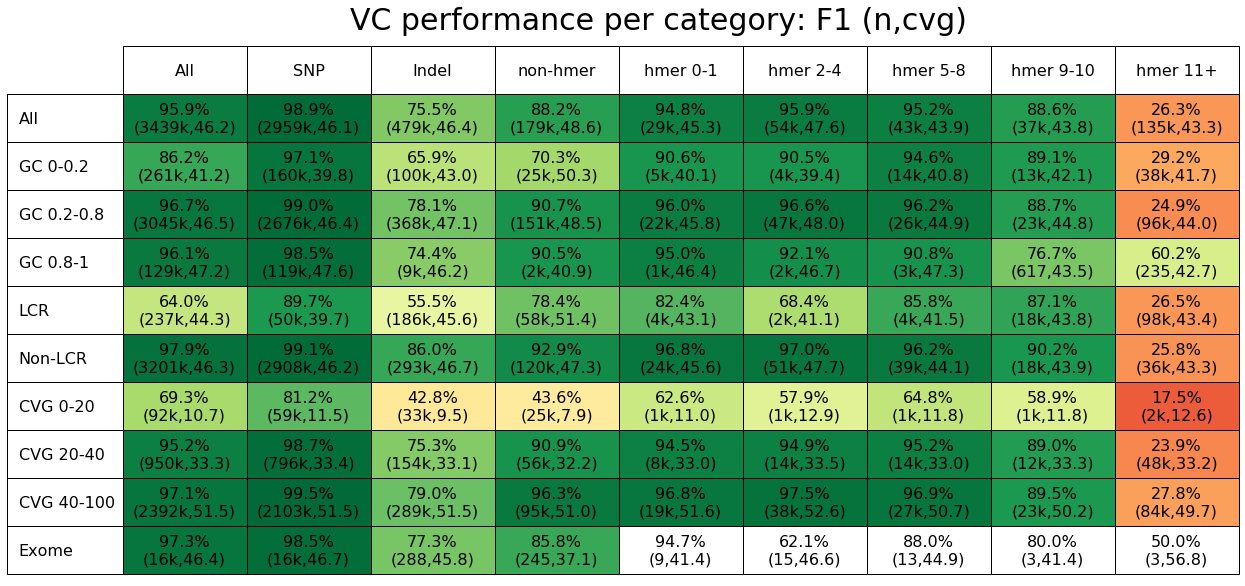

In [18]:
import numpy as np
import matplotlib.pyplot as plt

columns = varCats #[:3]
rows = ['All', 'GC 0-0.2', 'GC 0.2-0.8', 'GC 0.8-1', 'LCR', 'Non-LCR', 'CVG 0-20', 'CVG 20-40', 'CVG 40-100', 'Exome'] #[:3]

def getRow(cat,var):
    x=out[((((out['Category']=='All') & (out['Region']==cat)) | 
            ((out['Category']==cat) & (out['Region']=='All'))) & 
           (out['Variant']==var))]
    return x

def getTabTxt(cat,var):
    x=getRow(cat,var)
    n=x['# pos'].iloc[0] 
    num='{:d}k'.format(int(n/1000)) if n>1000 else '{:d}'.format(n)
    return '{:.1%}\n({:s},{:.1f})'.format(x['F1'].iloc[0],num,x['avg cvg'].iloc[0])

def getTabCol(cat,var):
    x=getRow(cat,var)
    if x['# pos'].iloc[0]<100:
        return 'white'
    return plt.cm.RdYlGn(x['F1'].iloc[0])


tabl = [[getTabTxt(r,c) for c in columns] for r in rows] 
tabcol = [[getTabCol(r,c) for c in columns] for r in rows] 

fig, ax = plt.subplots(figsize=(20,10)) 
ax.set_axis_off() 
table = ax.table( 
    cellText = tabl,  
    rowLabels = rows,  
    colLabels = columns,
    cellColours = tabcol,
    cellLoc ='center',  
    loc ='upper left')     
table.set_fontsize(30)
table.scale(1, 4)
x=plt.title('VC performance per category: F1 (n,cvg)', fontsize=30)